In [1]:
import os, joblib, torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import wasserstein_distance

from model import *
from utils import *
from data_loader import *
from test_metrics import *


# COSCI-GAN 디렉토리로 이동
path = '/workspace/COSCI-GAN_Journal'
try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory {0} does not exist".format(path))

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
set_seed(0)
sns.set(style="darkgrid")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: /workspace/COSCI-GAN_Journal


In [2]:
full_name = 'LSTM_LSTM_MLP_400_128_gamma_5.0_Glr_0.0005_Dlr_0.0005_CDlr_0.0001_seqlen_36_loss_BCE_eternal-rain-42'
seq_len = 252
n_groups = 5          # 학습한 자산 수
noise = torch.randn(500, 3, seq_len)

In [3]:
""" Find the best epochs based on 100 days distribution """
window = 100
generator = {}
best_epochs = [0] * n_groups
min_emd = [0] * n_groups

for asset_idx in range(0, n_groups):    
    min_distance = float('inf')  
    
    for asset_epoch in range(220, 251, 2): 
        # Load the generator       
        generator_tmp = LSTMGenerator(3, 1)
        generator_temp_dict = torch.load(f'./Results/{full_name}/Generator_{asset_idx}_{asset_epoch}.pt')            
        new_generator_temp_dict = deepcopy(generator_temp_dict)             
        for key in generator_temp_dict.keys():
            new_generator_temp_dict[key[7:]] = new_generator_temp_dict.pop(key)
        generator_tmp.load_state_dict(new_generator_temp_dict)                          
        
        # Generate the synthetic data
        fake = generator_tmp(noise).cpu().detach().squeeze()               
        fake, real = inverse_process(fake, asset_idx)
        if fake.size == 0:            
            continue
        
        # Calculate the EMD
        real_dist = rolling_window(real, window).sum(axis=0).ravel()
        fake_dist = rolling_window(fake.T, window).sum(axis=0).ravel()        
        emd = wasserstein_distance(real_dist, fake_dist)        
        
        # Update the best epochs 
        if emd < min_distance:
            min_distance = emd
            best_epochs[asset_idx] = asset_epoch        
            min_emd[asset_idx] = min_distance    
            generator[asset_idx] = generator_tmp
            print(f"min_distance:{min_distance}, best_epochs:{asset_epoch}")
    print()

print()
print(f"best_epochs = {best_epochs}")
print(f"min_emd = {min_emd}")

min_distance:0.08741502562958034, best_epochs:220
min_distance:0.04532899214637945, best_epochs:228
min_distance:0.025272355882238723, best_epochs:232
min_distance:0.016641760037116333, best_epochs:250

min_distance:0.09832353257361118, best_epochs:220
min_distance:0.08909808312781697, best_epochs:224
min_distance:0.03172191849855053, best_epochs:228
min_distance:0.020058757967013167, best_epochs:240
min_distance:0.015259991422466717, best_epochs:250

min_distance:0.13953725121030572, best_epochs:220
min_distance:0.06574720762782518, best_epochs:222
min_distance:0.01638553046889387, best_epochs:224

min_distance:0.06831728297133179, best_epochs:220
min_distance:0.011282642098141232, best_epochs:224

min_distance:0.13178660139393586, best_epochs:220
min_distance:0.10475252403343763, best_epochs:224
min_distance:0.05500371374149689, best_epochs:232


best_epochs = [250, 250, 224, 224, 232]
min_emd = [0.016641760037116333, 0.015259991422466717, 0.01638553046889387, 0.011282642098141232, 0

In [4]:
""" 데이터 생성 """
real = []
fake_list = []
real_list = []
                         # 생성할 데이터의 길이
noise = torch.randn(5000, 3, seq_len)

for i in range(0, n_groups):
    
    fake = generator[i](noise).cpu().detach().squeeze()    
    fake, log_returns = inverse_process(fake, i)        

    #fake = fake[(fake.max(axis=1) <= 2.0 * log_returns.max()) & (fake.min(axis=1) >= 2.0 * log_returns.min())]
    print(fake.shape)
    
    fake_list.append(fake)
    real.append(log_returns)

for i in range(len(real)):        
    real_list.append(np.array(rolling_window_seqlen(real[i], seq_len)).squeeze())
    
# 데이터 저장
joblib.dump(real_list, './Output/real_list.pkl')
joblib.dump(fake_list, './Output/fake_list.pkl')

# Function to save each array in the list to CSV files
def save_list_to_csv(data_list, filename_prefix):
    for i, data in enumerate(data_list):
        df = pd.DataFrame(data)
        df.to_csv(f'./Output/{filename_prefix}_{i}.csv', index=False)

# Save the data_list to CSV files
save_list_to_csv(fake_list, 'COSCI-GAN')

(5000, 252)
(5000, 252)
(5000, 252)
(5000, 252)
(5000, 252)


In [5]:
print(type(real))
print(len(real), real[0].shape, '\n')

print(type(real_list))
print(len(real_list), real_list[0].shape, '\n')

print(type(fake_list))
print(len(fake_list), fake_list[0].shape)

<class 'list'>
5 (5031, 1) 

<class 'list'>
5 (4779, 252) 

<class 'list'>
5 (5000, 252)


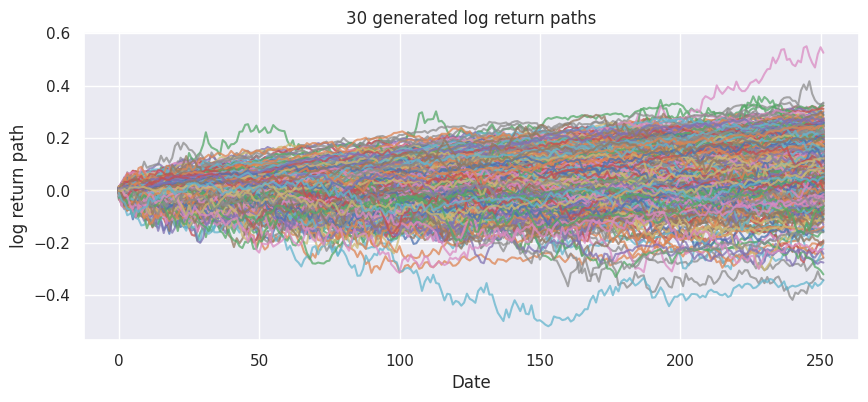

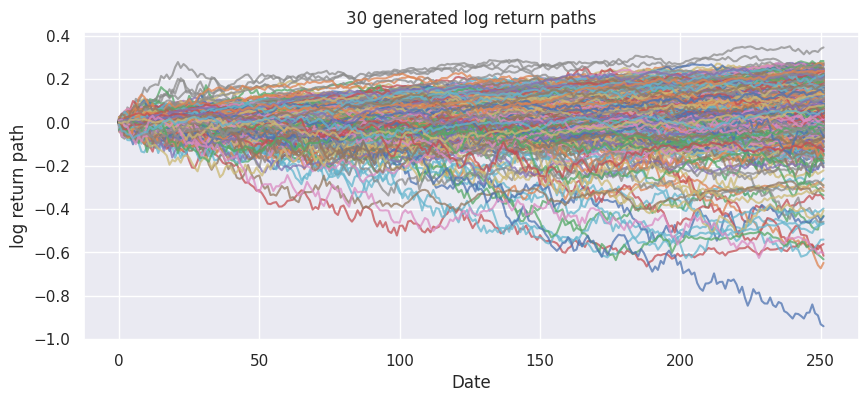

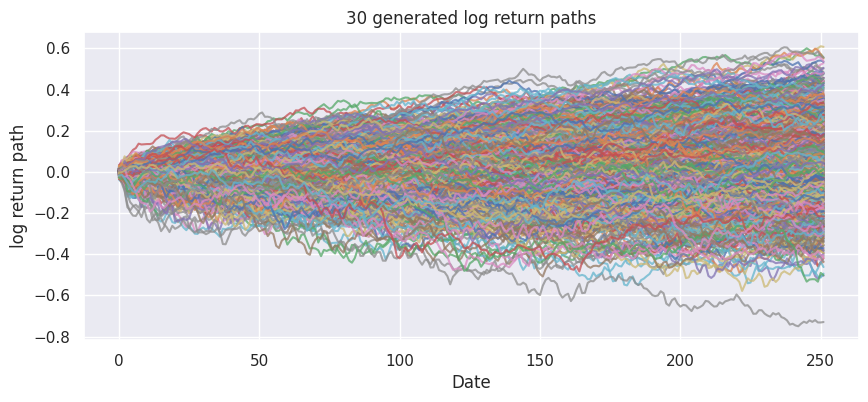

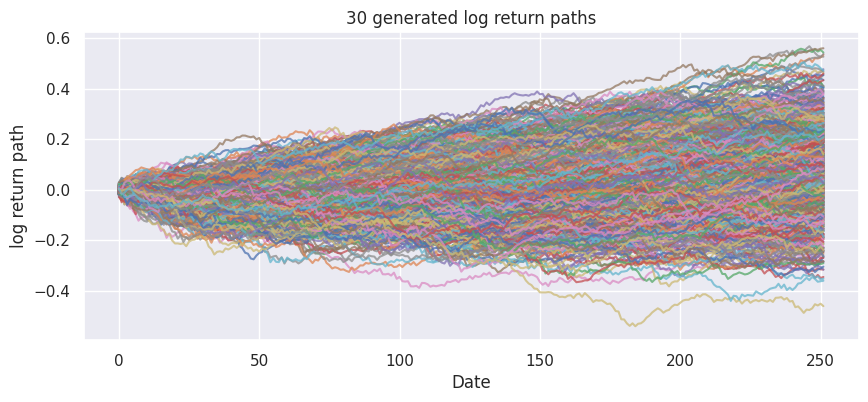

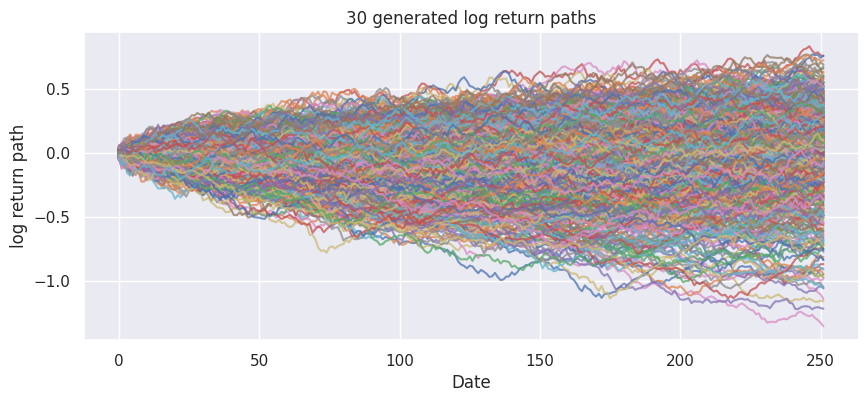

In [6]:
# # plot the 30 generated log return paths
for i in range(5):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(np.cumsum(fake_list[i][0:1000], axis=1).T, alpha=0.75)
    ax.set_title('30 generated log return paths')
    ax.set_xlabel('Date')

    ax.set_ylabel('log return path')

In [7]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Calculate EMD scores
results_emd = calculate_distribution_scores(real, fake_list, n_groups, windows)
results_emd

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4  EMD_avg
 window size                                                 
 1            0.0011  0.0011  0.0013  0.0012  0.0029   0.0015
 5            0.0018  0.0016  0.0034  0.0026  0.0094   0.0037
 20           0.0062  0.0064  0.0067  0.0030  0.0161   0.0077
 100          0.0160  0.0154  0.0183  0.0118  0.0545   0.0232,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4
 window size                                        
 1            0.0707  0.0703  0.0614  0.1241  0.0882
 5            0.0408  0.0395  0.0423  0.1061  0.1771
 20           0.1001  0.0771  0.0610  0.0366  0.1622
 100          0.1118  0.0914  0.1051  0.0327  0.3228,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4
 window size                                        
 1            0.0885  0.0918  0.0843  0.1172  0.0905
 5            0.0655  0.0606  0.0762  0.0970  0.1374
 20           0.0991  0.0956  0.0920  0.0796  0.1035
 100          0.1180  0.

In [8]:
# windows = [1, 5, 20, 100]
# for j in range(n_groups):
#     fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(32, 6))  

#     for i in range(len(windows)):
#         col = i

#         real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
#         fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
#         # 두 데이터의 최소값과 최대값을 계산
#         min_val = real_dist.min()
#         max_val = real_dist.max()

#         # 동일한 bin 경계 계산 (간격 동일하게)
#         bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
#         sns.histplot(real_dist, bins=bins, kde=True, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
#         sns.histplot(fake_dist, bins=bins, kde=True, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

#         axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
#         axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
#         axs[col].yaxis.grid(True, alpha=0.5)
#         axs[col].set_xlabel('Cumulative log return', fontsize=12)
#         axs[col].set_ylabel('Frequency', fontsize=12)

#     axs[0].legend(['Historical returns', 'Synthetic returns'])

# plt.show()

In [9]:
# Correlation Analysis of synthetic data
df_fake = []        
for i in range(n_groups):
    
    y = generator[i](noise).cpu().detach().squeeze()
    y, log_returns = inverse_process(y, i)        
    
    df = pd.DataFrame(y)    
    df_fake.append(df)
    
df_fake_merge = pd.concat(df_fake, axis=1)
corr_fake, avg_fake, _ = calculate_correlation(df_fake_merge, seq_len)

### Correlation Analysis - real data
real_merge = np.transpose(np.stack(real_list), axes=(1, 0, 2))
real_merge = real_merge.reshape(real_merge.shape[0], -1)
df_real_merge = pd.DataFrame(real_merge)
_, avg_real, _ = calculate_correlation(df_real_merge, seq_len)


Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.973164  0.176024 -0.067099  0.177974
Asset2  0.973164  1.000000  0.193072 -0.086081  0.167700
Asset3  0.176024  0.193072  1.000000  0.264019  0.053722
Asset4 -0.067099 -0.086081  0.264019  1.000000  0.130708
Asset5  0.177974  0.167700  0.053722  0.130708  1.000000

Standard Deviation of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  0.000000  0.029314  0.082568  0.063118  0.073531
Asset2  0.029314  0.000000  0.086086  0.063759  0.077537
Asset3  0.082568  0.086086  0.000000  0.058256  0.091954
Asset4  0.063118  0.063759  0.058256  0.000000  0.065359
Asset5  0.073531  0.077537  0.091954  0.065359  0.000000

Mean of synthetic data correlation
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.964640  0.211340  0.017327  0.244287
Asset2  0.964640  1.000000  0.201571 -0.002676  0.232082
Asset3  0.211340  0.201

In [10]:
mae = calculate_mae(avg_real, avg_fake)
mae_mean, mae_std = calculate_mae_mean(avg_real, corr_fake)

frobenius = calculate_frobenius(avg_real, avg_fake)
spearman = calculate_spearman(avg_real, avg_fake)
kendall = calculate_kendall(avg_real, avg_fake)


print("MAE mean:", mae)
print("Frobenius", frobenius)
print("Spearman", spearman)
print("Kendall:", kendall)
print("MAE mean:", mae_mean, "MAE std:", mae_std)

MAE mean: 0.05709182345628187
Frobenius 0.3919364160789352
Spearman 0.8007782101167316
Kendall: 0.6857142857142856
MAE mean: 0.07203073399685286 MAE std: 0.018169321228012715


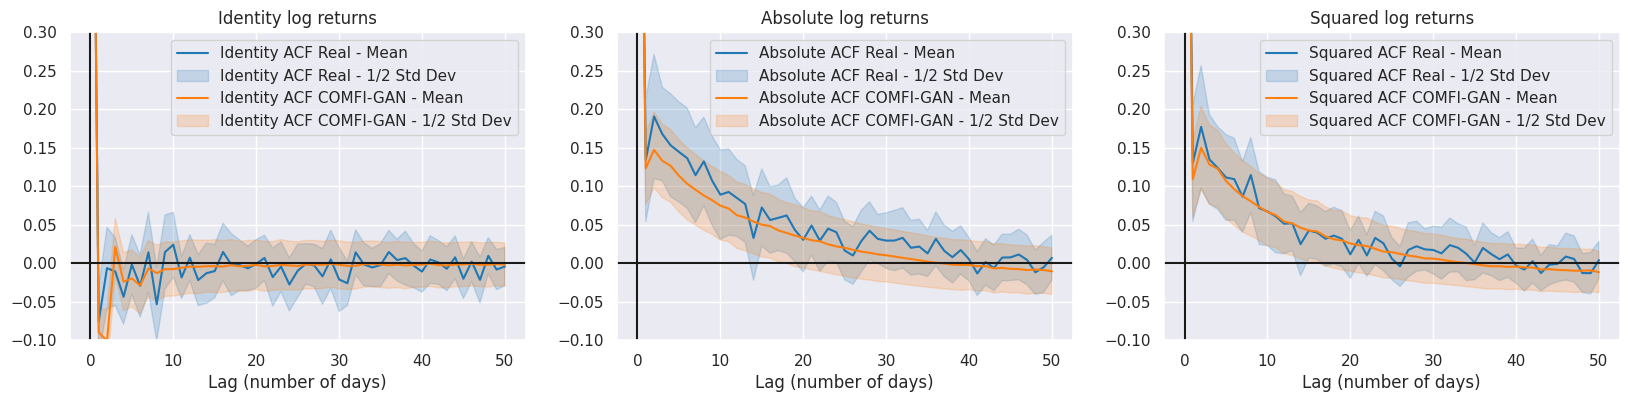

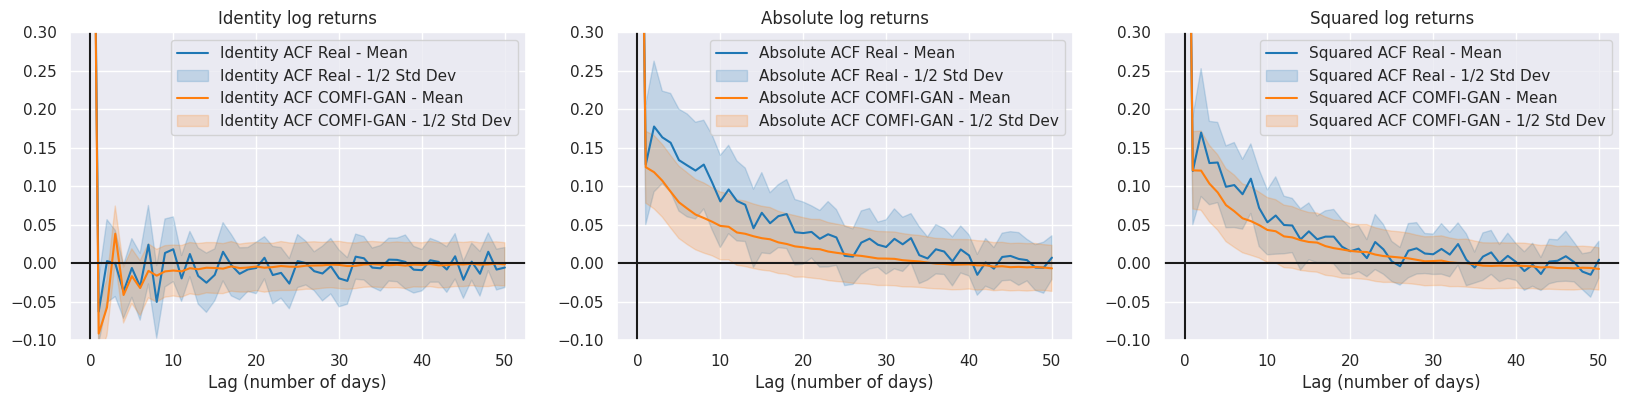

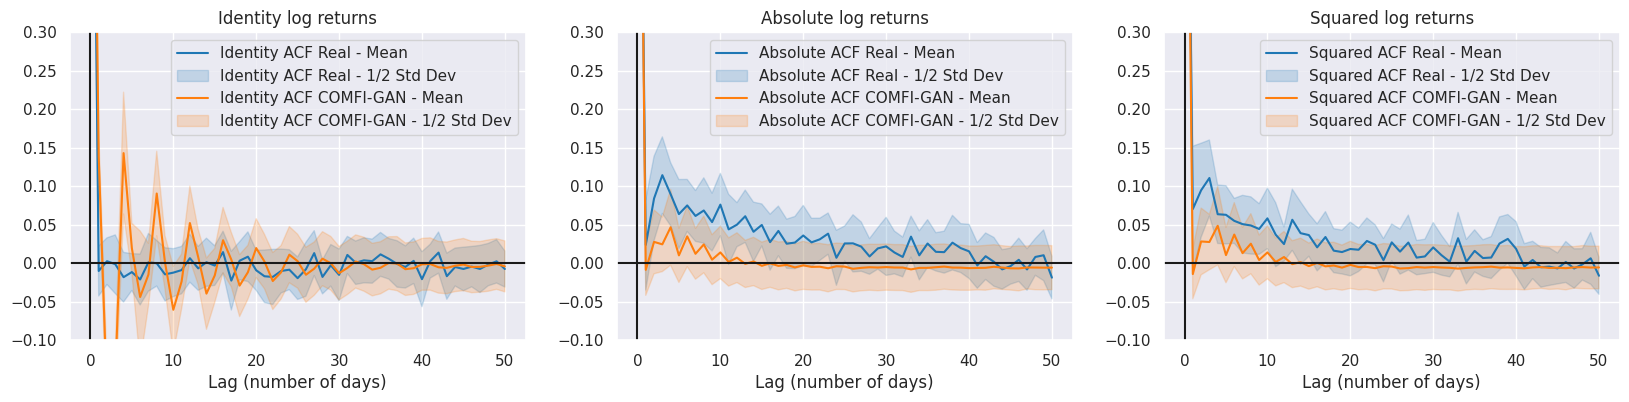

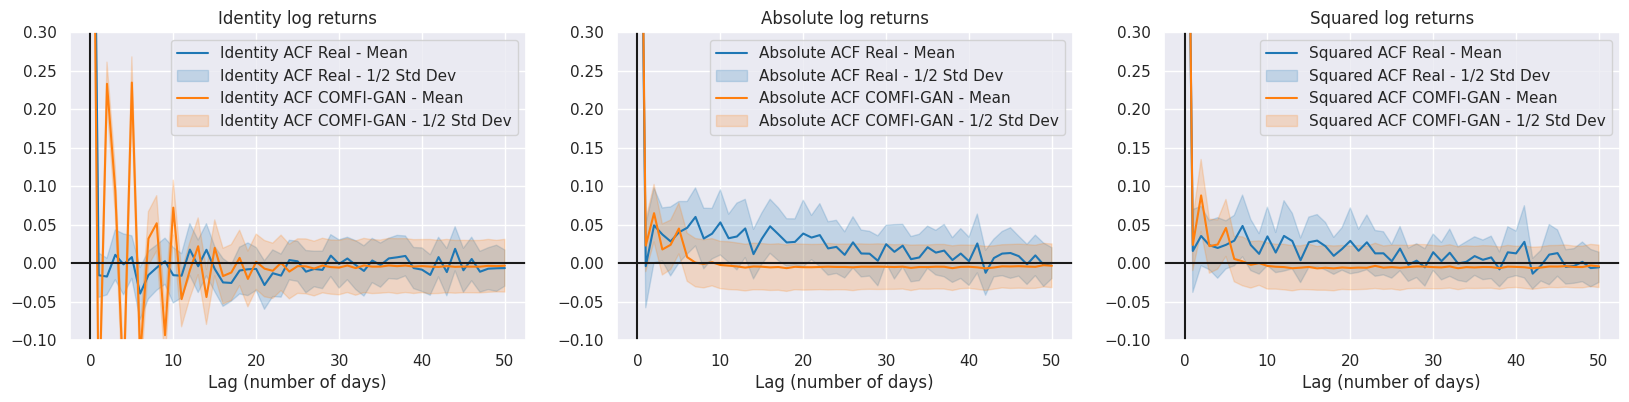

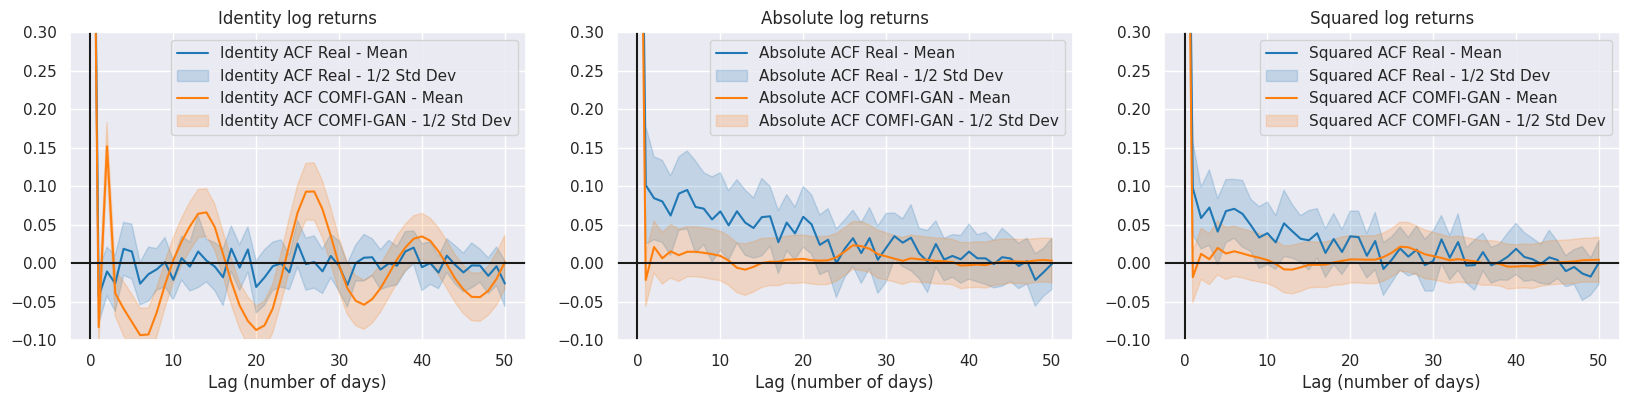

In [11]:
# ACF 비교 플롯
plot_acf_comparison(real_list, fake_list, n_groups, lags=50)

In [12]:
acf_score = calculate_acf_score(real_list, fake_list)

# Display the scores for each group
for group, scores in acf_score.items():
    print(f"{group}:")
    for title, score in scores.items():
        print(f"  {title}: {score}")


Group 1:
  Identity log returns: 0.1399
  Absolute log returns: 0.1419
  Squared log returns: 0.088
Group 2:
  Identity log returns: 0.1203
  Absolute log returns: 0.2147
  Squared log returns: 0.1263
Group 3:
  Identity log returns: 0.3532
  Absolute log returns: 0.2518
  Squared log returns: 0.2249
Group 4:
  Identity log returns: 0.4749
  Absolute log returns: 0.2006
  Squared log returns: 0.1531
Group 5:
  Identity log returns: 0.3749
  Absolute log returns: 0.2962
  Squared log returns: 0.2264


In [13]:
# calculate_skew_kurt_diff(fake_list, real_list)

In [14]:
# calculate_leverage_effect(fake_list, real_list)

In [15]:
def calculate_acf_score_120(real_list, fake_list, lags=40):
    data_transforms = [lambda x: x, np.abs, np.square]  # Identity 변환 추가
    titles = ['Identity log returns', 'Absolute log returns', 'Squared log returns']
    acf_scores = {}
    
    n_groups = len(real_list)
    
    for i in range(n_groups):
        group_scores = {}
        
        for transform, title in zip(data_transforms, titles):
            transformed_real = transform(real_list[i])
            transformed_fake = transform(fake_list[i])
            
            # transformed_real = transformed_real[:, -120:]
            # transformed_fake = transformed_fake[:, -120:]            
            
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
            
            mean_real = np.mean(acf_real, axis=0)
            mean_fake = np.mean(acf_fake, axis=0)
            std_real = np.std(acf_real, axis=0)
            std_fake = np.std(acf_fake, axis=0)
    
            group_scores[title] = {
                'mean': np.round(np.linalg.norm(mean_real - mean_fake), decimals=4),
                'std': np.round(np.linalg.norm(std_real - std_fake), decimals=4)
            }
        
        acf_scores[f'Group {i+1}'] = group_scores
    
    # 각 변환별로 모든 그룹의 mean과 std의 평균 계산
    avg_scores = {}
    for title in titles:
        mean_avg = np.mean([acf_scores[f'Group {i+1}'][title]['mean'] for i in range(n_groups)])
        std_avg = np.mean([acf_scores[f'Group {i+1}'][title]['std'] for i in range(n_groups)])
        
        avg_scores[title] = {
            'mean_avg': np.round(mean_avg, decimals=4),
            'std_avg': np.round(std_avg, decimals=4)
        }
    
    return acf_scores, avg_scores


# ACF 점수 계산 함수 호출
acf_scores, avg_scores = calculate_acf_score_120(real_list, fake_list, lags=40)

# 각 그룹의 ACF 점수 출력
# for group, scores in acf_scores.items():
#     print(f"Results for {group}:")
#     for title, values in scores.items():
#         print(f"  {title}:")
#         print(f"    Mean: {values['mean']}")
#         print(f"    Std: {values['std']}")
#     print("\n")

# 각 변환별 전체 평균 점수 출력
print("Average Scores across all groups:")
for title, values in avg_scores.items():
    print(f"  {title}:")
    print(f"    Mean Average: {values['mean_avg']}")
    print(f"    Std Average: {values['std_avg']}")

Average Scores across all groups:
  Identity log returns:
    Mean Average: 0.2959
    Std Average: 0.0927
  Absolute log returns:
    Mean Average: 0.1253
    Std Average: 0.0709
  Squared log returns:
    Mean Average: 0.1051
    Std Average: 0.073


In [16]:
def calculate_leverage_effect_120(real_list, fake_list, lags=40):
    def leverage_effect(ts, tau):
        rt = ts[:-tau]  # rt: 시계열에서 뒤에서 tau만큼 제외한 것
        rt_squared = (ts[tau:]**2)  # rt_tau_squared: 시계열에서 앞에서 tau만큼 제외하고 제곱한 것
        return np.corrcoef(rt, rt_squared)[0, 1]

    n_groups = len(real_list)
    leverage_scores = {}

    for i in range(n_groups):
        real_data = real_list[i]
        fake_data = fake_list[i]
        
        # real_data = real_data[:, -120:]
        # fake_data = fake_data[:, -120:]

        real_leverage_effects = np.array([[leverage_effect(ts, tau) for tau in range(1, lags+1)] for ts in real_data])
        fake_leverage_effects = np.array([[leverage_effect(ts, tau) for tau in range(1, lags+1)] for ts in fake_data])

        mean_real_leverage = np.mean(real_leverage_effects, axis=0)
        mean_fake_leverage = np.mean(fake_leverage_effects, axis=0)
        
        leverage_score = np.linalg.norm(mean_real_leverage - mean_fake_leverage)
        
        leverage_scores[f'Group {i+1}'] = np.round(leverage_score, decimals=4)
        
        # Print the result for the current group
        print(f'Group {i+1} leverage score: {leverage_scores[f"Group {i+1}"]}')
    # Calculate and print the average leverage score across all groups
    average_leverage_score = np.mean(list(leverage_scores.values()))
    print(f'Average leverage score across all groups: {np.round(average_leverage_score, decimals=4)}')

    return leverage_scores

calculate_leverage_effect_120(fake_list, real_list, lags=40)

Group 1 leverage score: 0.1075
Group 2 leverage score: 0.1081
Group 3 leverage score: 0.1245
Group 4 leverage score: 0.1411
Group 5 leverage score: 0.1755
Average leverage score across all groups: 0.1313


{'Group 1': 0.1075,
 'Group 2': 0.1081,
 'Group 3': 0.1245,
 'Group 4': 0.1411,
 'Group 5': 0.1755}

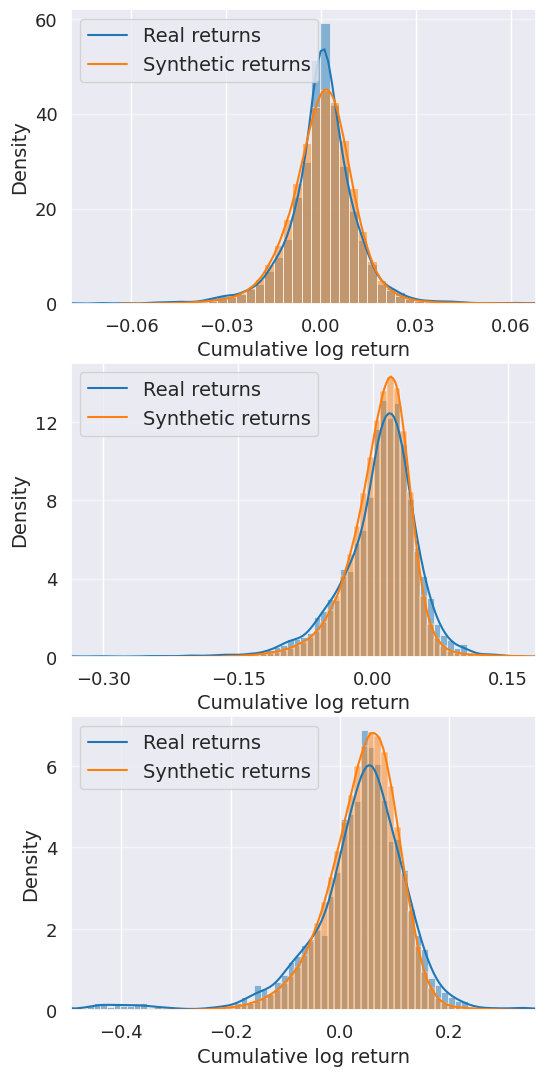

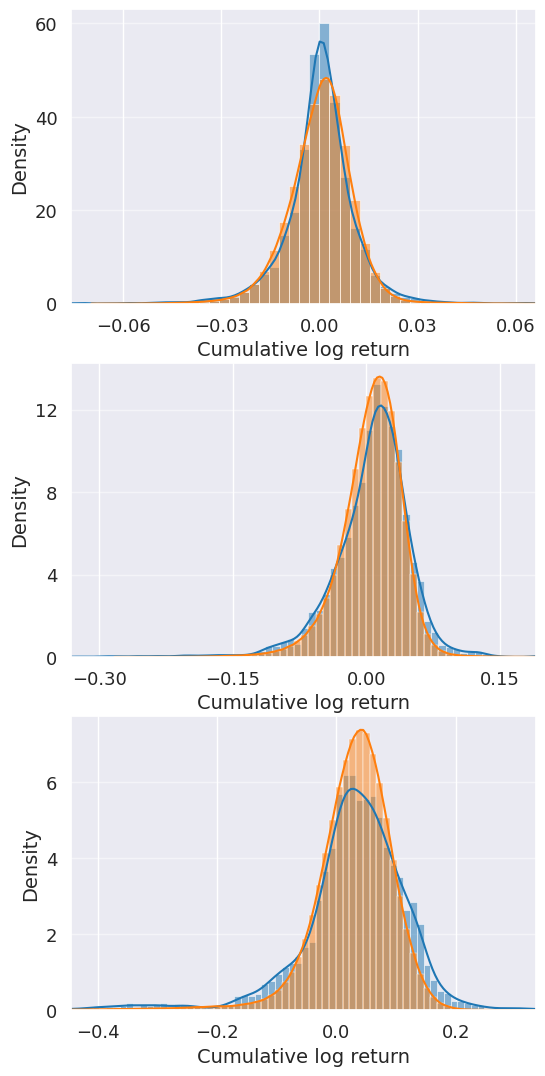

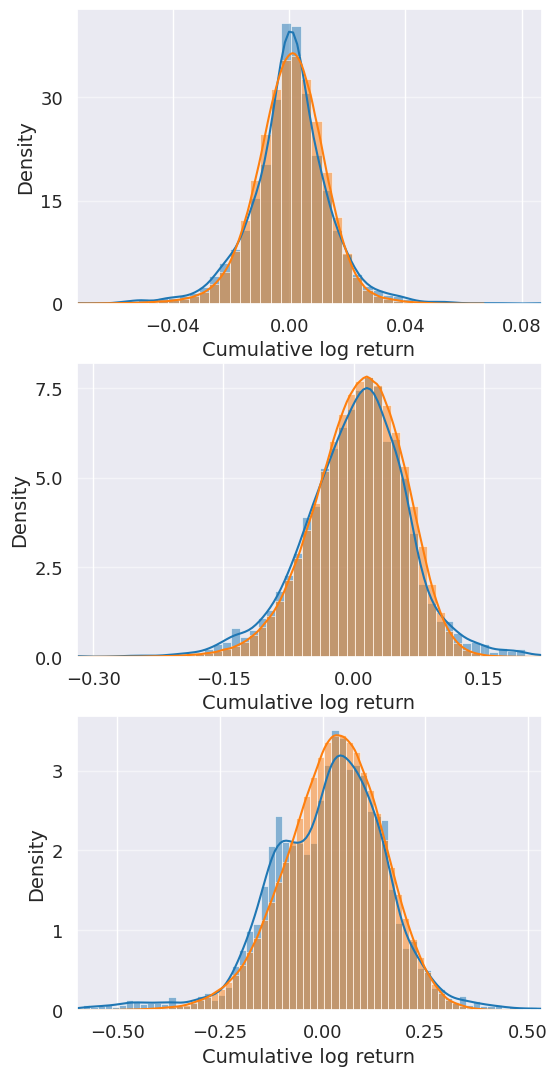

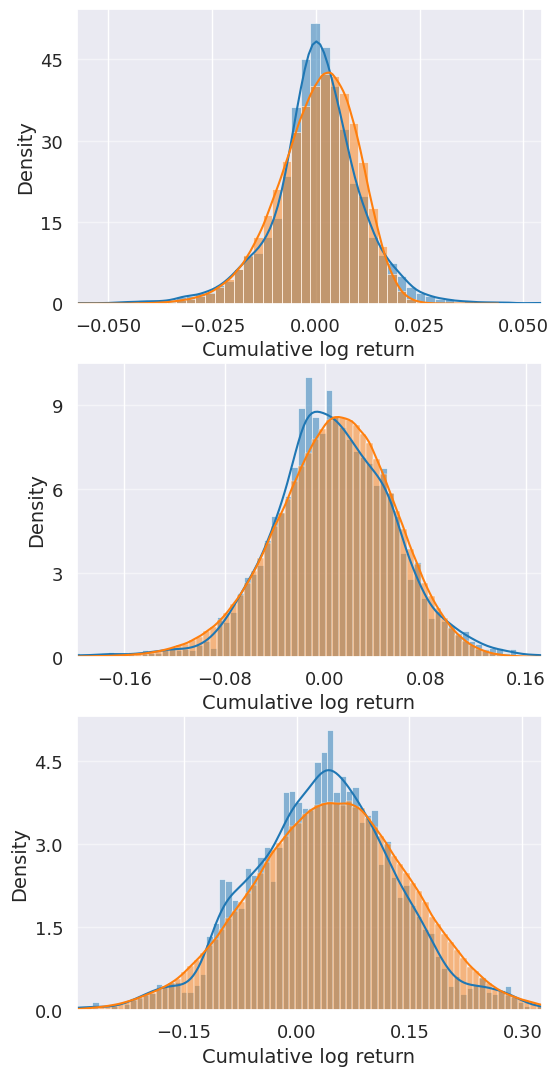

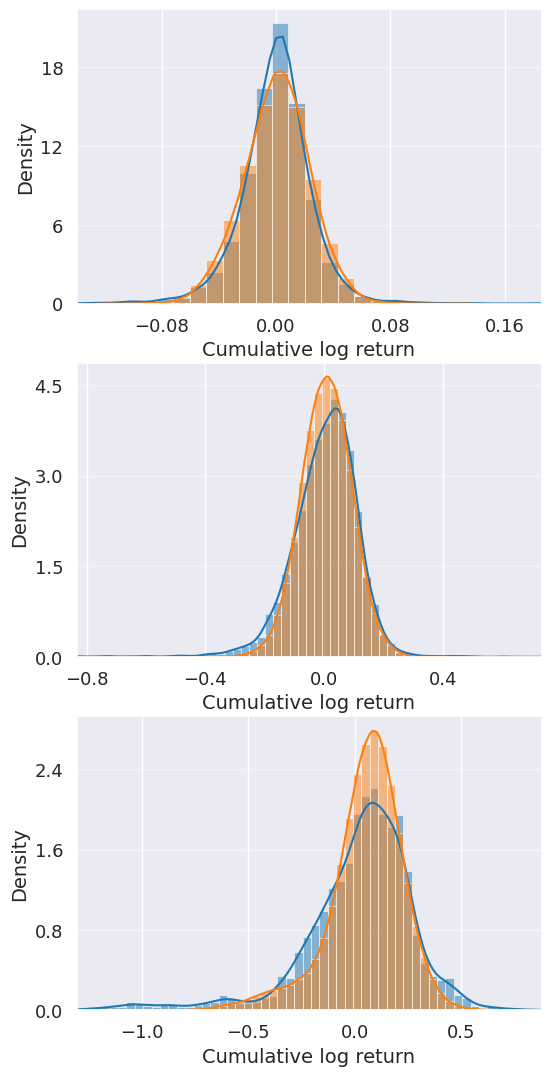

In [17]:
from matplotlib.ticker import MaxNLocator

windows = [1, 20, 100]
for j in range(5):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 13))  

    for i in range(len(windows)):
        ax = axs[i]  # 올바른 서브플롯 선택

        real_dist = rolling_window(real[j], windows[i]).sum(axis=0).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=0).ravel()
        
        # 두 데이터의 최소값과 최대값을 계산
        min_val = real_dist.min()
        max_val = real_dist.max()

        # 동일한 bin 경계 계산 (간격 동일하게)
        bins = np.linspace(min_val, max_val, 81)  # 80개의 bin 경계 생성
        
        sns.histplot(real_dist, bins=bins, kde=True, ax=ax, color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=True, ax=ax, color='tab:orange', alpha=0.5, stat='density')

        ax.set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        ax.tick_params(axis='x', labelsize=13)
        ax.tick_params(axis='y', labelsize=13)
        ax.yaxis.grid(True, alpha=0.5)
        ax.set_xlabel('Cumulative log return', fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        
        # x축 간격 조정
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        if j == 0:
            ax.legend(['Real returns', 'Synthetic returns'], fontsize=14, loc='upper left',)
#fig.tight_layout()  # 서브플롯 간의 간격 자동 조정
plt.show()

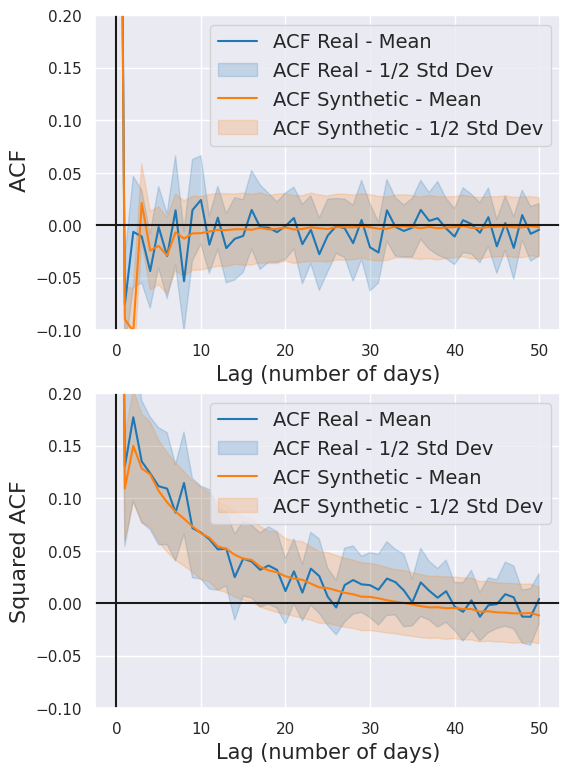

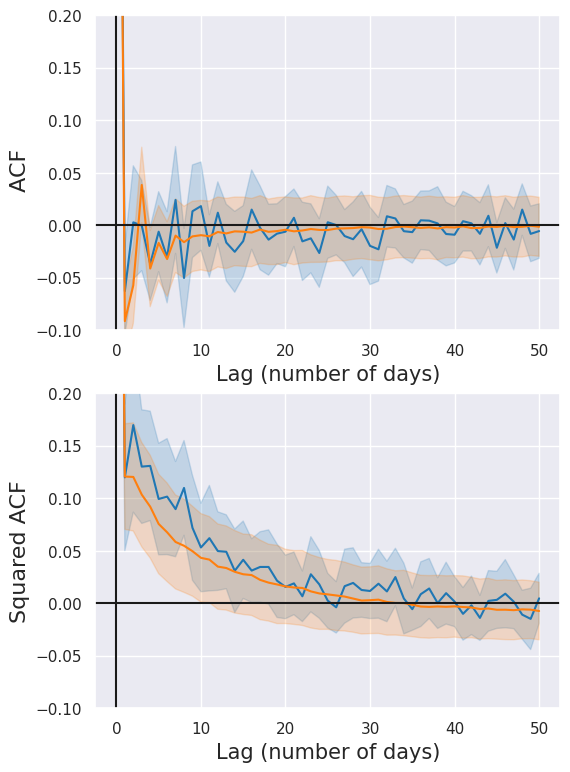

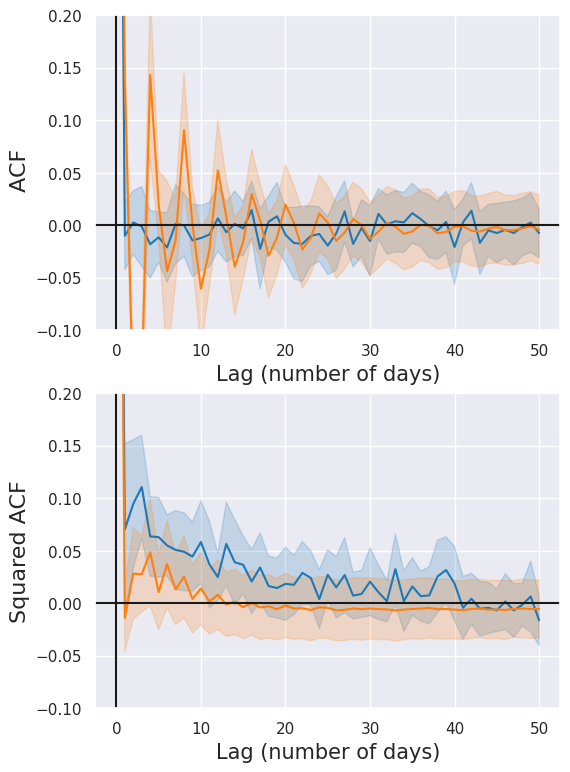

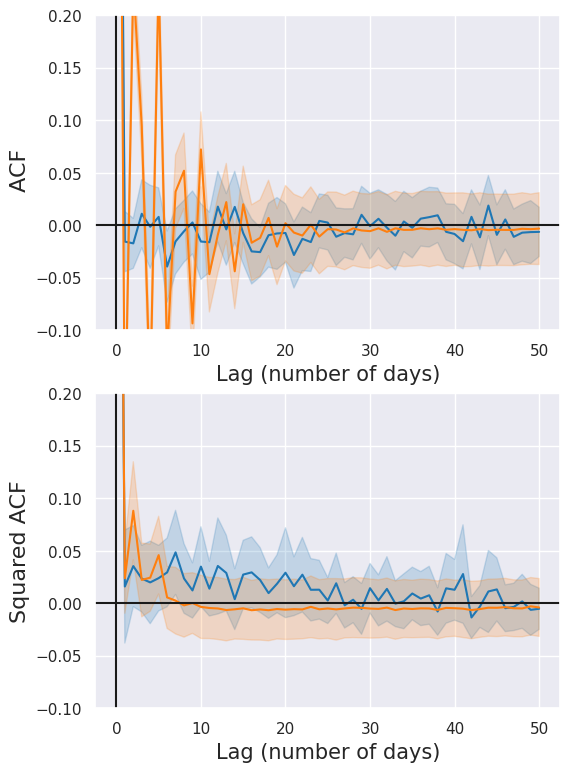

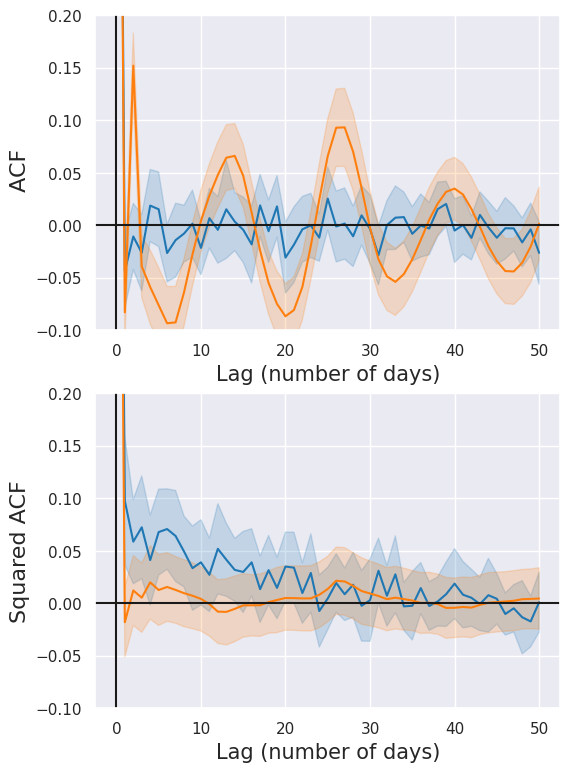

In [18]:
lags=50
data_types = ['Identity', 'Squared']
data_transforms = [lambda x: x, np.square]  # Identity 변환 추가
titles = ['', 'Squared']

for i in range(n_groups):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 9))  # 3개의 서브플롯 생성

    for ax, data_type, transform, title in zip(axs, data_types, data_transforms, titles):
        # 데이터 변환 및 ACF 계산
        transformed_real = transform(real_list[i])
        transformed_fake = transform(fake_list[i])
        
        acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
        acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
        
        mean_real = np.mean(acf_real, axis=0)
        std_real = np.std(acf_real, axis=0)
        mean_fake = np.mean(acf_fake, axis=0)
        std_fake = np.std(acf_fake, axis=0)
        
        # 평균 ACF와 표준편차 기반 범위 표시
        ax.plot(mean_real, label=f'ACF Real - Mean', color='tab:blue')
        ax.fill_between(range(lags+1), mean_real - 0.5*std_real, mean_real + 0.5*std_real, color='tab:blue', alpha=0.2,
                        label=f'ACF Real - 1/2 Std Dev')        
        ax.plot(mean_fake, label=f'ACF Synthetic - Mean', color='tab:orange')
        ax.fill_between(range(lags+1), mean_fake - 0.5*std_fake, mean_fake + 0.5*std_fake, color='tab:orange', alpha=0.2,
                        label=f'ACF Synthetic - 1/2 Std Dev')

        # 플롯 커스터마이징
        ax.set_ylim(-0.10, 0.20)
        #ax.set_title(title, fontsize=15)
        ax.grid(True)
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='k')
        ax.set_xlabel('Lag (number of days)', fontsize=15)
        ax.set_ylabel(f'{title} ACF', fontsize=16)
        if i==0:
            ax.legend(fontsize=14)

    plt.show()

<class 'pandas.core.frame.DataFrame'> (5, 5) Index(['Asset1', 'Asset2', 'Asset3', 'Asset4', 'Asset5'], dtype='object') Index(['Asset1', 'Asset2', 'Asset3', 'Asset4', 'Asset5'], dtype='object')
<class 'pandas.core.frame.DataFrame'> (5, 5) Index(['Asset1', 'Asset2', 'Asset3', 'Asset4', 'Asset5'], dtype='object') Index(['Asset1', 'Asset2', 'Asset3', 'Asset4', 'Asset5'], dtype='object')
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.964640  0.211340  0.017327  0.244287
Asset2  0.964640  1.000000  0.201571 -0.002676  0.232082
Asset3  0.211340  0.201571  1.000000  0.067097  0.147946
Asset4  0.017327 -0.002676  0.067097  1.000000  0.202344
Asset5  0.244287  0.232082  0.147946  0.202344  1.000000
          Asset1    Asset2    Asset3    Asset4    Asset5
Asset1  1.000000  0.973164  0.176024 -0.067099  0.177974
Asset2  0.973164  1.000000  0.193072 -0.086081  0.167700
Asset3  0.176024  0.193072  1.000000  0.264019  0.053722
Asset4 -0.067099 -0.086081  0.264019  1.0000

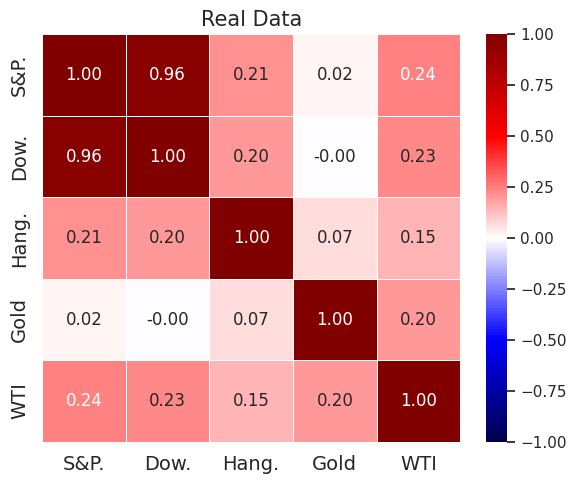

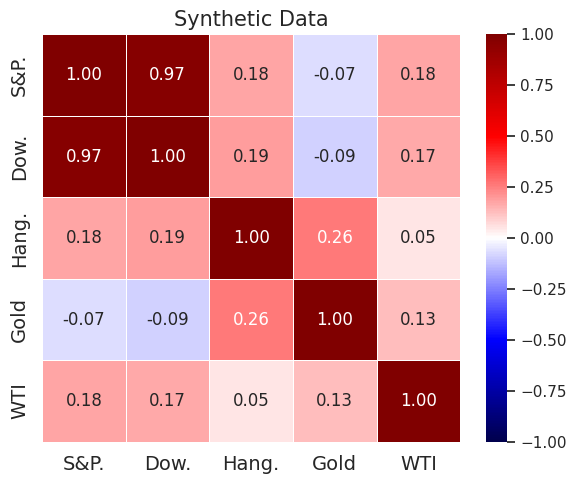

In [19]:
print(type(avg_real), avg_real.shape, avg_real.columns, avg_real.index)
print(type(avg_fake), avg_fake.shape, avg_fake.columns, avg_fake.index)
print(avg_real)
print(avg_fake)

new_names = ['S&P.', 'Dow.', 'Hang.', 'Gold', 'WTI']
# 열 이름 변경
avg_real.columns = new_names
avg_fake.columns = new_names

# 인덱스 이름 변경
avg_real.index = new_names
avg_fake.index = new_names

# 첫 번째 히트맵: avg_real에 대한 상관관계 히트맵
fig_real, ax_real = plt.subplots(figsize=(6, 5))  # 개별 figure와 axes 생성
sns.heatmap(avg_real, annot=True, cmap='seismic', linewidths=.5, ax=ax_real, fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
ax_real.set_title('Real Data', fontsize=15)
ax_real.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 첫 번째 히트맵 표시

# 두 번째 히트맵: avg_fake에 대한 상관관계 히트맵
fig_fake, ax_fake = plt.subplots(figsize=(6, 5))  # 개별 figure와 axes 생성
sns.heatmap(avg_fake, annot=True, cmap='seismic', linewidths=.5, ax=ax_fake, fmt=".2f", annot_kws={"size": 12}, vmin=-1, vmax=1)
ax_fake.set_title('Synthetic Data', fontsize=15)
ax_fake.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 두 번째 히트맵 표시

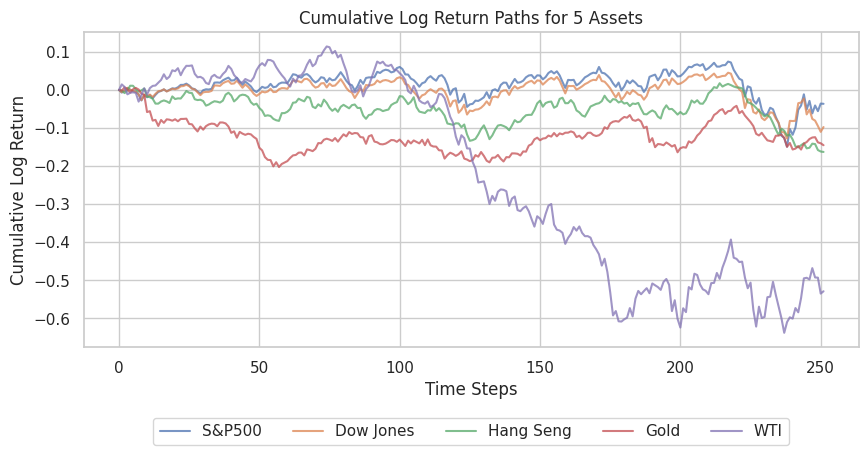

Correlation Matrix of Log Returns:
Corr(S&P500, Dow Jones): 0.94
Corr(S&P500, Hang Seng): 0.25
Corr(S&P500, Gold): 0.03
Corr(S&P500, WTI): 0.29
Corr(Dow Jones, Hang Seng): 0.26
Corr(Dow Jones, Gold): -0.00
Corr(Dow Jones, WTI): 0.30
Corr(Hang Seng, Gold): 0.28
Corr(Hang Seng, WTI): 0.26
Corr(Gold, WTI): 0.09


: 

In [22]:
sns.set(style="whitegrid")
#sns.set(style="white")


max_length = fake_list[0].shape[1]  # 데이터의 최대 길이 설정

# 첫 번째 샘플에서 5개의 자산에 대한 로그 리턴 시리즈를 생성
log_returns_all = []
idx = 5
for i in range(5):
    log_returns = fake_list[i][idx][:max_length]  # 로그 리턴 시리즈 추출
    log_returns_all.append(log_returns)

# 로그 리턴을 사용하여 상관관계 행렬 계산
log_returns_all = np.array(log_returns_all)
corr_matrix = np.corrcoef(log_returns_all)

# 새로운 자산 이름을 적용
new_names = ['S&P500', 'Dow Jones', 'Hang Seng', 'Gold', 'WTI']

# 누적 로그 리턴 경로를 그리기
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(5):
    cumulative_returns = np.cumsum(log_returns_all[i])  # 누적 로그 리턴 계산
    cumulative_returns -= cumulative_returns[0]  # 첫 번째 시점을 0으로 맞추기
    ax.plot(cumulative_returns, alpha=0.75, label=new_names[i])

# 레전드를 플롯 아래에 위치시키기
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5)

ax.set_title('Cumulative Log Return Paths for 5 Assets')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Cumulative Log Return')

# 하단 여백 조정
plt.subplots_adjust(bottom=0.25)

plt.show()

# 상관관계 정보를 출력
print("Correlation Matrix of Log Returns:")
for i in range(5):
    for j in range(i+1, 5):
        print(f'Corr({new_names[i]}, {new_names[j]}): {corr_matrix[i, j]:.2f}')
